# Final Model

Using:
- ResNet50
- EmoteAI0901
- EmoteAI0901Focal

In [2]:
!pip install --upgrade tensorflow==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 111.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

In [3]:
import numpy as np
import tensorflow.keras as K
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
img_train = '/content/drive/MyDrive/Colab Notebooks/ProyFinal/Achive/train'
# img_train = "train"


traindataset = K.utils.image_dataset_from_directory(img_train,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )

img_test = '/content/drive/MyDrive/Colab Notebooks/ProyFinal/Achive/test'
# img_test = "test"

testdataset = K.utils.image_dataset_from_directory(img_test,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )


Found 28729 files belonging to 7 classes.
Found 7208 files belonging to 7 classes.


In [6]:
def convert_to_rgb(image, label):
    image_rgb = tf.repeat(image, repeats=3, axis=-1)
    return image_rgb, label


traindataset = traindataset.map(convert_to_rgb)
testdataset = testdataset.map(convert_to_rgb)

In [7]:
ruta = '/content/drive/MyDrive/Colab Notebooks/Final/'

model1 = K.models.load_model(ruta + 'ResNet50.h5')
model2 = K.models.load_model(ruta + 'EmoteAI0901Focal200.h5')
model3 = K.models.load_model(ruta + 'EmoteAI0901.h5')

In [8]:
for layer in model1.layers:
    layer.trainable = False
for layer in model2.layers:
    layer.trainable = False
for layer in model3.layers:
    layer.trainable = False

In [9]:
model1._name = 'model1'
model2._name = 'model2'
model3._name = 'model3'

In [10]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Final/FinalModel.h5'
# model_path = 'FinalModel.h5'

input = K.Input(shape=(None, None, 3))

x = input

m1 = model1(x)
m2 = model2(x)
m3 = model3(x)

x = K.layers.concatenate([m1, m2, m3])

x = K.layers.Flatten()(x)

output = K.layers.Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model = K.Model(input, output)

model.compile(optimizer='adam',
              loss='categorical_focal_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model1 (Functional)         (None, 7)                    1239477   ['input_1[0][0]']             
                                                          19                                      
                                                                                                  
 model2 (Functional)         (None, 7)                    9062791   ['input_1[0][0]']             
                                                                                                  
 model3 (Functional)         (None, 7)                    9665168   ['input_1[0][0]']         

In [11]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

best = [K.callbacks.ModelCheckpoint(model_path,
                                   save_best_only=True),
       K.callbacks.LearningRateScheduler(scheduler),
       K.callbacks.EarlyStopping(monitor='val_loss',
                                patience=10,
                                verbose=1)
       ]

history = model.fit(traindataset,
                    validation_data=testdataset,
                    epochs=100,
                    verbose=True,
                    callbacks=best,
                    use_multiprocessing=True)

Epoch 1/100
898/898 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.5433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 2439s 3s/step - loss: 0.2218 - accuracy: 0.5433 - val_loss: 0.1662 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 2/100
898/898 [==============================] - 25s 28ms/step - loss: 0.1442 - accuracy: 0.6767 - val_loss: 0.1501 - val_accuracy: 0.6351 - lr: 9.0484e-04
Epoch 3/100
898/898 [==============================] - 28s 31ms/step - loss: 0.1302 - accuracy: 0.6832 - val_loss: 0.1469 - val_accuracy: 0.6355 - lr: 8.1873e-04
Epoch 4/100
898/898 [==============================] - 29s 31ms/step - loss: 0.1254 - accuracy: 0.6866 - val_loss: 0.1463 - val_accuracy: 0.6398 - lr: 7.4082e-04
Epoch 5/100
898/898 [==============================] - 29s 32ms/step - loss: 0.1197 - accuracy: 0.6979 - val_loss: 0.1461 - val_accuracy: 0.6411 - lr: 6.7032e-04
Epoch 6/100
898/898 [==============================] - 24s 26ms/step - loss: 0.1203 - accuracy: 0.6937 - val_loss: 0.1463 - val_accuracy: 0.6418 - lr: 6.0653e-04
Epoch 7/100
898/898 [=======================

In [12]:
print(type(history.history))
print(history.history.keys())
largo = len(history.history['accuracy'])
largo

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


15

In [13]:
print(type(history.history))
print(history.history.keys())
largo = len(history.history['accuracy'])
largo

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


15

In [14]:
prediction = model.predict(testdataset)

y_true = []
y_pred = []

for x, y in testdataset:
    predictions = model.predict(x)

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = np.argmax(y.numpy(), axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

1/1 [==============================] - 1s 1s/step


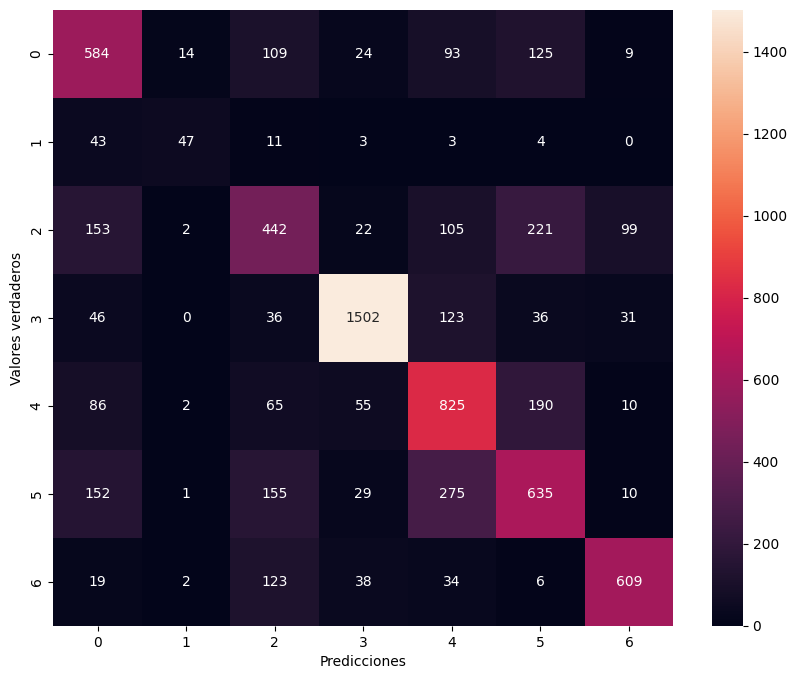

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.show()
